## Molecular Cross-Validation

In this notebook we demonstrate how to apply molecular cross-validation with an arbitary denoising method.

In [1]:
import csv
import gzip
import itertools
import pathlib

from typing import Callable, Mapping
from collections.abc import Sequence

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd

import scanpy as sc

import molecular_cross_validation.util as ut


In [2]:
# read in metadata file to get sample annotations
with gzip.open("../../data/myeloid/GSE72857_experimental_design.txt.gz", "rt") as f:
    rdr = csv.reader(f, delimiter='\t')
    row = next(rdr)
    for row in rdr:
        if row[0] == "Well_ID" and row[1] == "Seq_batch_ID":
            break

    rows = list(csv.DictReader(f, fieldnames=row, delimiter="\t"))

In [3]:
# read in text file as AnnData object
with gzip.open("../../data/myeloid/GSE72857_umitab.txt.gz", "rt") as f:
    myeloid_ad = sc.read_text(f, delimiter="\t", first_column_names=True).T

# filter to myeloid samples
myeloid_ids = [
    r["Well_ID"] for r in rows if r["Batch_desc"] == "Unsorted myeloid"
]
myeloid_ad = myeloid_ad[myeloid_ids, :]

# filter to ≥1000 UMIs per cell and ≥10 cells per gene
sc.pp.filter_cells(myeloid_ad, min_counts=1000)
sc.pp.filter_genes(myeloid_ad, min_cells=10)

umis = np.asarray(myeloid_ad.X.astype(int))

Trying to set attribute `.obs` of view, making a copy.


### Defining the denoiser

In this example we will use the simple diffusion method that was part of Figure 1.

In general, we need to define a function that takes an `numpy.ndarray` of UMIs and returns a denoised version. This function can take any form as long as the returned array is of the same shape and scale as the original data. Parameters for the denoiser are passed in as keyword arguments and will be calibrated by grid search using the MCV loss.

In [4]:
def compute_diff_op(
    umis: np.ndarray,
    n_components: int = 30,
    n_neighbors: int = 15,
    tr_prob: float = 0.5,
    random_state: np.random.RandomState = None,
):
    """Helper function for the diffusion denoiser, computes the diffusion operator
    as a lazy walk over a k-nearest-neighbors graph of the data in PC space.
    
    :param umis: The data being smoothed
    :param n_components: Number of components to use for PCA
    :param n_neighbors: Number of neighbors to use for kNN graph
    :param tr_prob: Transition probability for lazy walk
    :param random_state: For reproducible results
    :return: Transition matrix for diffusion over the graph
    """
    if random_state is None:
        random_state = np.random.RandomState()

    # calculate diffusion operator
    n_counts = np.median(umis.sum(axis=1))

    x1_norm = np.sqrt(umis / umis.sum(axis=1, keepdims=True) * n_counts)

    U, S, V = randomized_svd(x1_norm, n_components, random_state=random_state)

    p = U.dot(np.diag(S))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(p)

    diff_op = np.array(nbrs.kneighbors_graph(p, mode="connectivity").todense())
    diff_op += diff_op.T
    diff_op = diff_op / diff_op.sum(axis=1, keepdims=True)
    diff_op = tr_prob * diff_op + (1 - tr_prob) * np.eye(diff_op.shape[0])

    return diff_op


def gene_diffusion(umis: np.ndarray, time_steps: int, **diff_op_kwargs):
    """Diffuse gene values using a lazy walk over a kNN graph. First,
    calculates a kNN graph in PC space and uses that to define a diffusion
    operator. Next, iteratively smoothes the input data according to the
    operator, and returns the result.
    
    :param umis: The original data (possibly scaled or otherwise normalized)
    :param time_steps: Number of steps to take in the diffusion/walk
    :diff_op_kwargs: Additional arguments to pass to `compute_diff_op`
    :return: A denoised array of UMIs
    """
    # calculate the diffusion operator, e.g. a weighting over a kNN graph
    diff_op = compute_diff_op(umis, **diff_op_kwargs)
    diffused_umis = umis.copy().astype(np.float)

    # perform diffusion over the knn graph
    for t in range(time_steps):
        diffused_umis = diff_op.dot(diffused_umis)

    return diffused_umis

### Running an MCV grid search

The `run_mcv_sweep` function takes as input a denoiser, the original data, and a dictionary `sweep_kwargs`. This dictionary is of the form `keyword`: `sequence of values`, and defines the parameters of the grid search to be performed.

The function will split the original data into two parts, `X` and `Y`, according to the parameter `data_split` (default: 0.9 in X, 0.1 in Y). For each combination of parameters, the denoiser will be applied to `X` and evaluated on `Y`, and the resulting MCV loss will be recorded. A list of dictionaries returned, each one containing the parameters used the resulting loss.

In [5]:
mcv_d = ut.run_mcv_sweep(
    gene_diffusion,
    umis,
    data_split = 0.9,
    n_trials=1,
    sweep_kwargs={"time_steps": np.arange(3, 11), "n_components": [10, 20, 30, 40]}
)

After running the MCV sweep we can identify the optimal parameter settings, shown below.

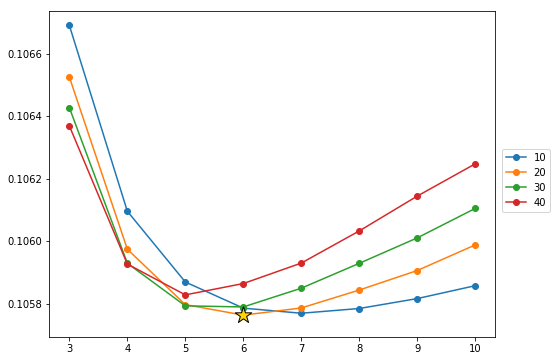

In [6]:
mcv_df = pd.DataFrame(mcv_d)

fig,ax = plt.subplots(1, 1, figsize=(8,6))

mcv_arr = mcv_df["mcv_loss"].values.reshape((8, 4), order="C")
line_obj = ax.plot(np.arange(3, 11), mcv_arr, marker="o")

# mark the optimal value
ax.scatter(
    [3 + mcv_arr.min(1).argmin()], [mcv_arr.min(1).min()], 
    marker="*", linewidths=1, edgecolor="k", s=300, c="gold", zorder=3
)

plt.figlegend(iter(line_obj), ('10', '20', '30', '40'), loc=7)
plt.show()